# Pyrenew demo
This demo simulates some basic renewal process data and then fits to it using `pyrenew`.

You'll need to install `pyrenew` first. You'll also need working installations of `matplotlib`, `numpy`, `jax`, `numpyro`, and `polars`

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpy as np
from numpyro.handlers import seed
import numpyro.distributions as dist

/home/xrd4/.cache/pypoetry/virtualenvs/pyrenew-e8bt3r2y-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


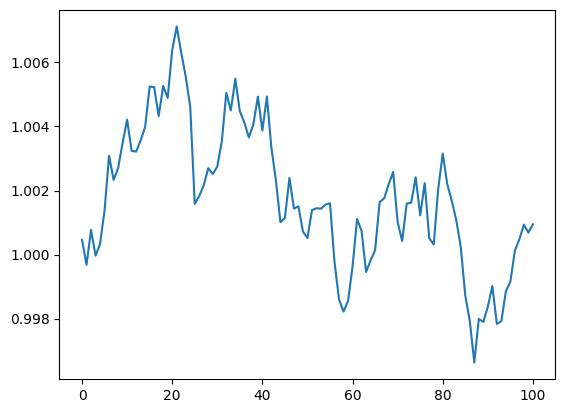

In [2]:
from pyrenew.processes import SimpleRandomWalkProcess

np.random.seed(3312)
q = SimpleRandomWalkProcess(dist.Normal(0, 0.001))
with seed(rng_seed=np.random.randint(0,1000)):
    q_samp = q.sample(duration=100)

plt.plot(np.exp(q_samp[0]))

In [3]:
from pyrenew.latent import Infections, HospitalAdmissions
from pyrenew.observations import PoissonObservation

from pyrenew.models import HospitalizationsModel
from pyrenew.processes import RtRandomWalkProcess

# Initializing model parameters
latent_infections = Infections(jnp.array([0.25, 0.25, 0.25, 0.25]))
latent_hospitalizations = HospitalAdmissions(
    inf_hosp_int=jnp.array(
        [0, 0, 0,0,0,0,0,0,0,0,0,0,0, 0.25, 0.5, 0.1, 0.1, 0.05],
        )
    )
observed_hospitalizations = PoissonObservation(
    rate_varname='latent',
    counts_varname='observed_hospitalizations',
    )
Rt_process = RtRandomWalkProcess()

# Initializing the model
hospmodel = HospitalizationsModel(
    latent_hospitalizations=latent_hospitalizations,
    observed_hospitalizations=observed_hospitalizations,
    latent_infections=latent_infections,
    Rt_process=Rt_process
    )

In [4]:
with seed(rng_seed=np.random.randint(1, 60)):
    x = hospmodel.sample(constants=dict(n_timepoints=30))
x

HospModelSample(Rt=Array([1.1791104, 1.1995267, 1.1772177, 1.1913829, 1.2075942, 1.1444623,
       1.1514508, 1.1976782, 1.2292639, 1.1719677, 1.204649 , 1.2323451,
       1.2466507, 1.2800207, 1.2749145, 1.2619376, 1.2189837, 1.2192641,
       1.2290158, 1.2128737, 1.1908046, 1.2174997, 1.1941082, 1.2084603,
       1.1965215, 1.2248698, 1.2308019, 1.2426206, 1.2131014, 1.207159 ,
       1.1837622], dtype=float32), infections=Array([ 1.4125489,  1.8606048,  2.373585 ,  3.1091077,  2.6433773,
        2.8573434,  3.161715 ,  3.5246303,  3.74528  ,  3.893561 ,
        4.314205 ,  4.76846  ,  5.211469 ,  5.8201566,  6.4110003,
        7.0072513,  7.4510007,  8.13536  ,  8.911782 ,  9.553016 ,
       10.137069 , 11.181891 , 11.876529 , 12.9149685, 13.793039 ,
       15.239348 , 16.561634 , 18.176119 , 19.339912 , 20.919167 ,
       22.194605 ], dtype=float32), IHR=Array(0.04929917, dtype=float32), latent=Array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0

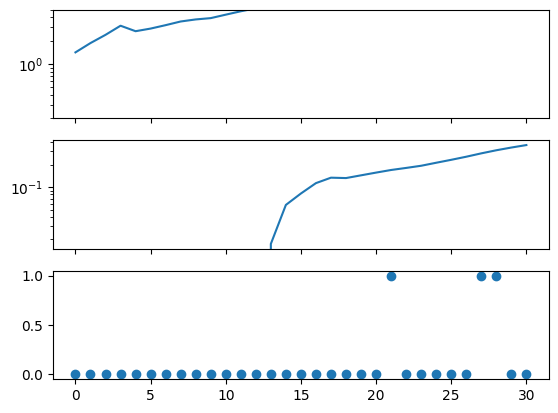

In [5]:
fig, ax = plt.subplots(nrows=3, sharex=True)
ax[0].plot(x.infections)
ax[0].set_ylim([1/5, 5])
ax[1].plot(x.latent)
ax[2].plot(x.sampled, 'o')
for axis in ax[:-1]:
    axis.set_yscale("log")

In [6]:
sim_dat={"observed_hospitalizations": x.sampled}
constants = {"n_timepoints":len(x.sampled)-1}

# from numpyro.infer import MCMC, NUTS
hospmodel.run(
    num_warmup=1000,
    num_samples=1000,
    random_variables=sim_dat,
    constants=constants,
    rng_key=jax.random.PRNGKey(54),
    )

sample: 100%|██████████| 2000/2000 [00:02<00:00, 789.32it/s, 7 steps of size 5.03e-01. acc. prob=0.89] 


In [7]:
hospmodel.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
                         I0      7.14      1.75      6.83      4.19      9.62   1169.36      1.00
                        IHR      0.05      0.00      0.05      0.05      0.05   1844.78      1.00
                        Rt0      1.13      0.12      1.13      0.92      1.31   1060.51      1.00
 Rt_transformed_rw_diffs[0]     -0.00      0.02     -0.00     -0.04      0.04   1417.77      1.00
 Rt_transformed_rw_diffs[1]     -0.00      0.02      0.00     -0.04      0.04   1715.37      1.00
 Rt_transformed_rw_diffs[2]     -0.00      0.02     -0.00     -0.04      0.04   1720.77      1.00
 Rt_transformed_rw_diffs[3]     -0.00      0.02     -0.00     -0.04      0.04   2099.10      1.00
 Rt_transformed_rw_diffs[4]     -0.00      0.02     -0.00     -0.04      0.04   1791.33      1.00
 Rt_transformed_rw_diffs[5]      0.00      0.03     -0.00     -0.04      0.04   1621.04      1.00
 Rt_transformed_rw_

In [8]:
from pyrenew.mcmcutils import spread_draws
samps = spread_draws(hospmodel.mcmc.get_samples(), [("Rt", "time")])

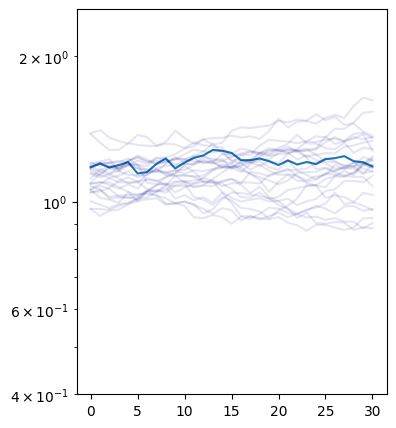

In [9]:
import numpy as np
import polars as pl
fig, ax = plt.subplots(figsize=[4, 5])

ax.plot(x[0])
samp_ids = np.random.randint(size=25, low=0, high=999)
for samp_id in samp_ids:
    sub_samps = samps.filter(pl.col("draw") == samp_id).sort(pl.col('time'))
    ax.plot(sub_samps.select("time").to_numpy(), 
            sub_samps.select("Rt").to_numpy(), color="darkblue", alpha=0.1)
ax.set_ylim([0.4, 1/.4])
ax.set_yticks([0.5, 1, 2])
ax.set_yscale("log")
